In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import pyplot as plt
from matplotlib import patches
import plotly.graph_objects as go
import plotly.express as px

In [3]:
dataset_base_path = '../data/clevr/CLEVR_CoGenT_v1.0/images/' 
x_train = []
for img in os.listdir(dataset_base_path + 'trainA'):
    x_train.append(dataset_base_path + 'trainA/' + img)
print(len(x_train))
print(x_train[:5])

70000
['../data/clevr/CLEVR_CoGenT_v1.0/images/trainA/CLEVR_trainA_029042.png', '../data/clevr/CLEVR_CoGenT_v1.0/images/trainA/CLEVR_trainA_033921.png', '../data/clevr/CLEVR_CoGenT_v1.0/images/trainA/CLEVR_trainA_002477.png', '../data/clevr/CLEVR_CoGenT_v1.0/images/trainA/CLEVR_trainA_044565.png', '../data/clevr/CLEVR_CoGenT_v1.0/images/trainA/CLEVR_trainA_016856.png']


(320, 480, 4)


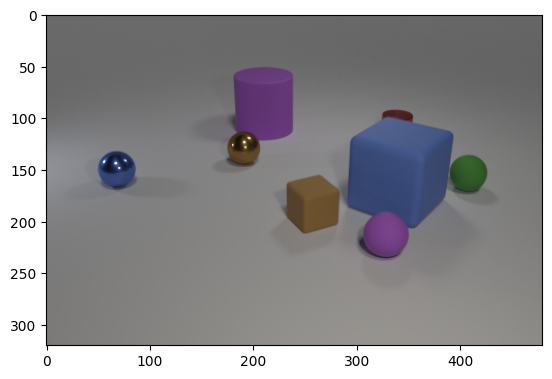

In [63]:
idx = random.randint(0, len(x_train))
img = plt.imread(x_train[idx])
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)
plt.imshow(img)
plt.show()

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [37]:
# Load the pre-trained Faster R-CNN with ResNet-50 FPN model
faster_rcnn = fasterrcnn_resnet50_fpn(
    weights='DEFAULT',
    num_classes=91,
    weights_backbone='DEFAULT',
    trainable_backbone_layers=0,
)

In [38]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
# dict of labels
labels = {i: weights.meta["categories"][i] for i in range(1, 91)}
# labels

In [ ]:
# Extract the regional features from the model
def extract_regional_features(model, input_image):
    regional_features, _, _ = model(input_image)
    return regional_features

# Create a new model that takes the input image and regional features as input
class NewModel(nn.Module):
    def __init__(self, num_classes):
        super(NewModel, self).__init__()
        # self.fc1 = nn.Linear(2048 + 3 * 224 * 224, 1024)
        self.fc1 = nn.Linear(2048 + 3 * INPUT_SHAPE[0] * INPUT_SHAPE[1], 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, input_image, regional_features):
        x = torch.cat((input_image.view(input_image.shape[0], -1), regional_features.view(regional_features.shape[0], -1)), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = NewModel(91)

# Pass an input image through the Faster R-CNN with ResNet-50 FPN model to get the regional features
input_image = torch.rand(1, 3, 224, 224)
regional_features = extract_regional_features(faster_rcnn, input_image)

# Pass the input image and regional features through the new model to get the predictions
predictions = model(input_image, regional_features)

print("Predictions:", predictions)

In [40]:
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

(320, 480, 3)


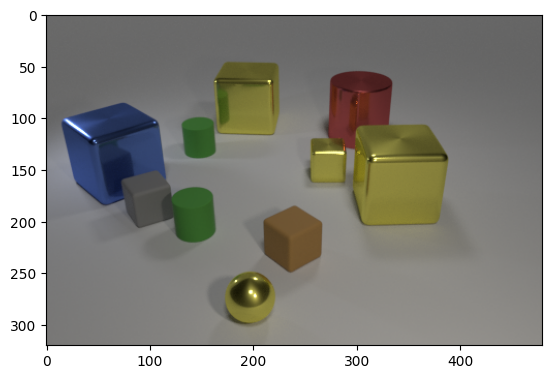

In [54]:
idx = random.randint(0, len(x_train))
img = plt.imread(x_train[idx])
# 4 to 3 channels
img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

In [58]:
# For inference
# x = [torch.rand(3, 300, 400).cuda(), torch.rand(3, 500, 400).cuda()]
# x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]

x = [torch.from_numpy(img).permute(2, 0, 1).float().to(device),]
preds = model(x)
preds

[{'boxes': tensor([[121.1473, 166.8329, 164.9501, 222.0097],
          [131.6531,  99.0068, 164.2837, 139.5916],
          [273.4038,  55.3951, 337.1258, 156.5706],
          [ 13.3872,  85.3228, 120.4932, 189.3710],
          [296.2352, 105.8638, 391.2222, 204.1598],
          [ 14.3415,  50.3565, 416.6121, 308.0140],
          [  0.0000,  49.1335, 480.0000, 314.5392],
          [298.2670, 106.5457, 384.7904, 201.9635],
          [ 13.1023,  82.4187, 120.4591, 192.9876],
          [ 14.7474,  87.3905, 114.4512, 187.6482],
          [130.9170,  99.2351, 165.0464, 140.8029],
          [294.5846, 102.3816, 391.9541, 199.2538],
          [300.4325, 109.3321, 387.4692, 194.9118]], device='cuda:1',
         grad_fn=<StackBackward0>),
  'labels': tensor([47, 47, 47, 80, 33, 82, 67, 80, 70, 72, 44, 47, 82], device='cuda:1'),
  'scores': tensor([0.9343, 0.8522, 0.4927, 0.2041, 0.1821, 0.1731, 0.1590, 0.1548, 0.1479,
          0.1246, 0.1112, 0.1055, 0.0864], device='cuda:1',
         grad_fn=<

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


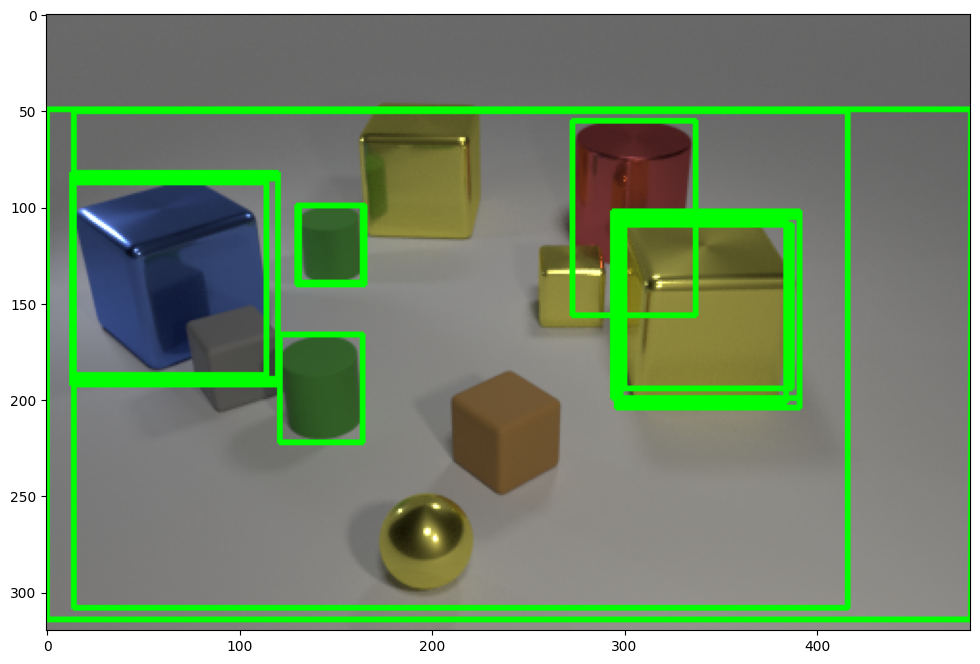

In [56]:
# show x[0] with bounding boxes
img_with_boxes = x[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, figsize=(16, 8))
for box in preds[0]['boxes']:
    box = box.cpu().detach().numpy().astype(np.int32)
    cv2.rectangle(img_with_boxes, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
ax.imshow(img_with_boxes)
plt.show()

In [57]:
for i in range(len(preds[0]["labels"])):
    lbl = preds[0]["labels"][i].item()
    tag = labels.get(lbl)
    score = preds[0]["scores"][i].item()
    print(lbl, tag, score)

47 cup 0.9343475699424744
47 cup 0.8521816730499268
47 cup 0.4927122890949249
80 toaster 0.20408090949058533
33 suitcase 0.18206030130386353
82 refrigerator 0.1731458455324173
67 dining table 0.15895497798919678
80 toaster 0.15477854013442993
70 toilet 0.14786705374717712
72 tv 0.1246134415268898
44 bottle 0.11118315160274506
47 cup 0.1054806187748909
82 refrigerator 0.08635902404785156
